# 🚀 Fine-Tuning LLaMA for Product Pricing Prediction 💰

Welcome to this comprehensive Google Colab notebook!  
This guide is intended how to fine-tune **Large Language Models (LLMs)** — specifically a **LLaMA-based model** — for a real-world application: **Product Price Estimation**.

We’ll walk through the entire process, from data loading and preparation to model training and evaluation, using powerful libraries such as:

- 🤗 `transformers` and `datasets` by Hugging Face  
- 🧩 `PEFT` (Parameter-Efficient Fine-Tuning)  
- 🧠 LLaMA-based models for text regression tasks

---

Let’s get started! 🎉


### 🧹 Data Curation – Part 1: Focusing on Home Appliances

To begin the data preparation process, we will curate a focused subset of the dataset related to **Home Appliances**. This ensures that our fine-tuning task remains domain-specific and relevant to our price prediction objective.

📦 **Dataset Source:**  
We will be using the **Amazon Reviews 2023** dataset curated by McAuley Lab:

- 🔗 [Main Dataset on Hugging Face](https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023)  
- 📁 [Directory of All Product Categories](https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023/tree/main/raw/meta_categories)

This dataset includes detailed product metadata and customer reviews across multiple categories. For our task, we will extract and clean data specific to the **Home Appliances** category.

In [ ]:
# imports

import os
import random
from huggingface_hub import login
from datasets import load_dataset, Dataset, DatasetDict
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import numpy as np
import pickle

In [ ]:
!pip install datasets --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 12.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pla

In [ ]:
## login to hugging face
from google.colab import userdata
hf_token=userdata.get('HF_TOKEN')
login(hf_token, add_to_git_credential=True)

In [ ]:
from items import Item
%matplotlib inline

In [ ]:
# Load in our dataset

dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", f"raw_meta_Appliances", split="full")

README.md:   0%|          | 0.00/30.3k [00:00<?, ?B/s]

Amazon-Reviews-2023.py:   0%|          | 0.00/39.6k [00:00<?, ?B/s]

In [ ]:
print(f"Number of Appliances: {len(dataset):,}")

Number of Appliances: 94,327


In [ ]:
# Investigate a particular datapoint
datapoint = dataset[2]
print(datapoint["title"])
print(datapoint["description"])
print(datapoint["features"])
print(datapoint["details"])
print(datapoint["price"])

Clothes Dryer Drum Slide, General Electric, Hotpoint, WE1M333, WE1M504
['Brand new dryer drum slide, replaces General Electric, Hotpoint, RCA, WE1M333, WE1M504.']
[]
{"Manufacturer": "RPI", "Part Number": "WE1M333,", "Item Weight": "0.352 ounces", "Package Dimensions": "5.5 x 4.7 x 0.4 inches", "Item model number": "WE1M333,", "Is Discontinued By Manufacturer": "No", "Item Package Quantity": "1", "Batteries Included?": "No", "Batteries Required?": "No", "Best Sellers Rank": {"Tools & Home Improvement": 1315213, "Parts & Accessories": 181194}, "Date First Available": "February 25, 2014"}
None


In [ ]:
# How many have prices?

prices = 0
for datapoint in dataset:
    try:
        price = float(datapoint["price"])
        if price > 0:
            prices += 1
    except ValueError as e:
        pass

print(f"There are {prices:,} with prices which is {prices/len(dataset)*100:,.1f}%")

There are 46,726 with prices which is 49.5%


In [ ]:
# For those with prices, gather the price and the length

prices = []
lengths = []
for datapoint in dataset:
    try:
        price = float(datapoint["price"])
        if price > 0:
            prices.append(price)
            contents = datapoint["title"] + str(datapoint["description"]) + str(datapoint["features"]) + str(datapoint["details"])
            lengths.append(len(contents))
    except ValueError as e:
        pass

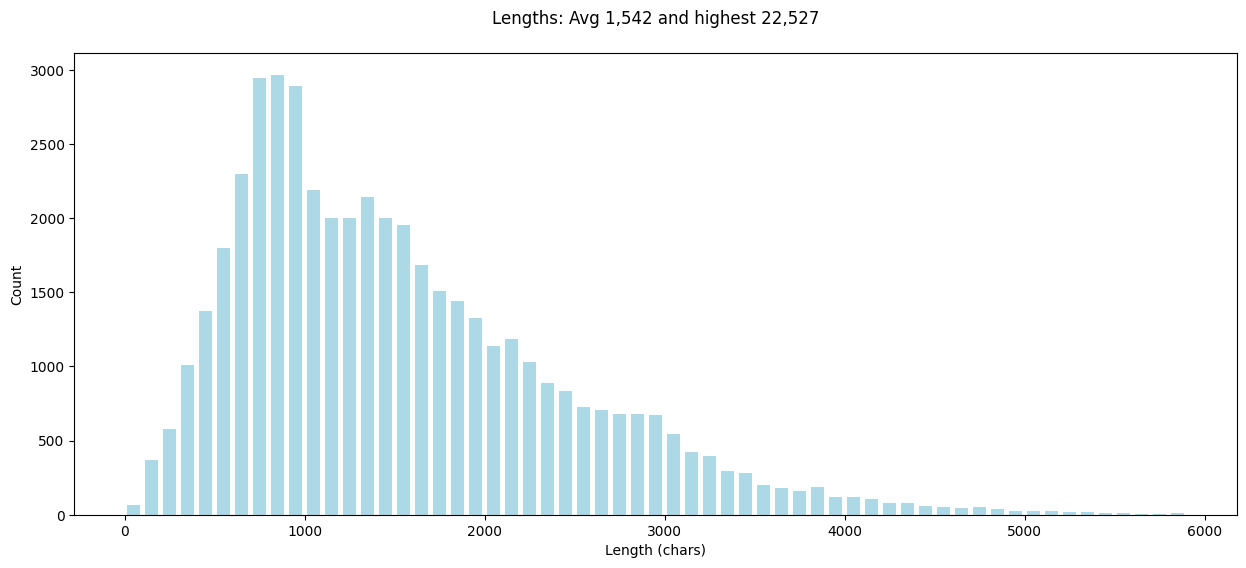

In [ ]:
# Plot the distribution of lengths

plt.figure(figsize=(15, 6))
plt.title(f"Lengths: Avg {sum(lengths)/len(lengths):,.0f} and highest {max(lengths):,}\n")
plt.xlabel('Length (chars)')
plt.ylabel('Count')
plt.hist(lengths, rwidth=0.7, color="lightblue", bins=range(0, 6000, 100))
plt.show()

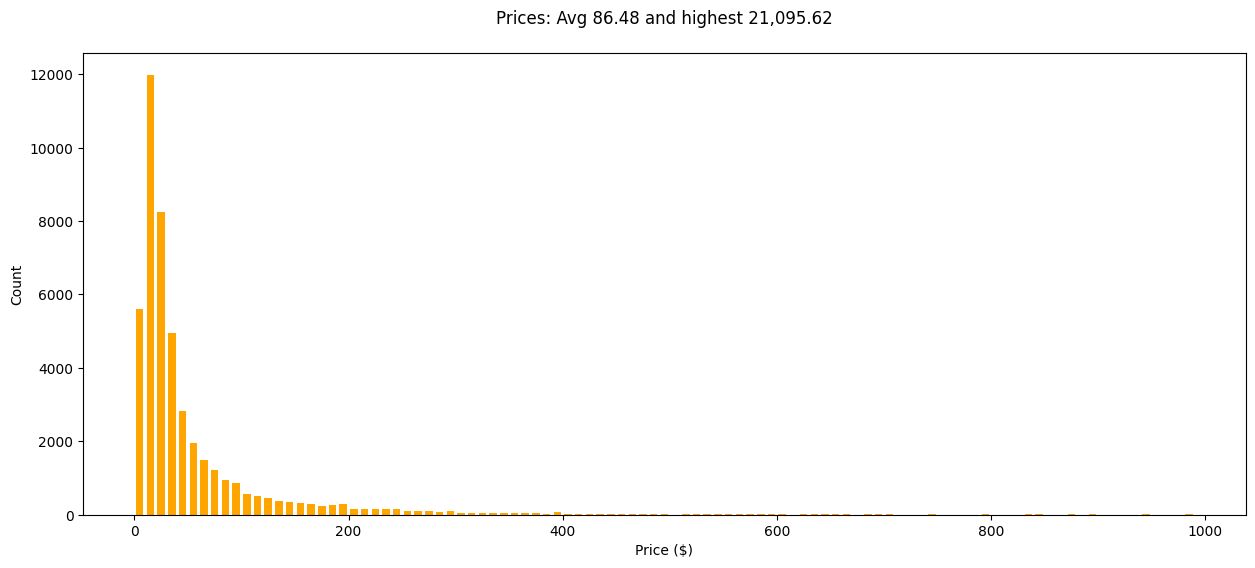

In [ ]:
# Plot the distribution of prices

plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.2f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="orange", bins=range(0, 1000, 10))
plt.show()

In [ ]:
# Create an Item object for each with a price

items = []
for datapoint in dataset:
    try:
        price = float(datapoint["price"])
        if price > 0:
            item = Item(datapoint, price)
            if item.include:
                items.append(item)
    except ValueError as e:
        pass

print(f"There are {len(items):,} items")

There are 29,191 items


In [ ]:
# Investigate the prompt that will be used during training - the model learns to complete this

print(items[100].prompt)

How much does this cost to the nearest dollar?

Samsung Assembly Ice Maker-Mech
This is an O.E.M. Authorized part, fits with various Samsung brand models, oem part # this product in manufactured in south Korea. This is an O.E.M. Authorized part Fits with various Samsung brand models Oem part # This is a Samsung replacement part Part Number This is an O.E.M. part Manufacturer J&J International Inc., Part Weight 1 pounds, Dimensions 18 x 12 x 6 inches, model number Is Discontinued No, Color White, Material Acrylonitrile Butadiene Styrene, Quantity 1, Certification Certified frustration-free, Included Components Refrigerator-replacement-parts, Rank Tools & Home Improvement Parts & Accessories 31211, Available April 21, 2011

Price is $118.00


In [ ]:
# Investigate the prompt that will be used during testing - the model has to complete this

print(items[100].test_prompt())

How much does this cost to the nearest dollar?

Samsung Assembly Ice Maker-Mech
This is an O.E.M. Authorized part, fits with various Samsung brand models, oem part # this product in manufactured in south Korea. This is an O.E.M. Authorized part Fits with various Samsung brand models Oem part # This is a Samsung replacement part Part Number This is an O.E.M. part Manufacturer J&J International Inc., Part Weight 1 pounds, Dimensions 18 x 12 x 6 inches, model number Is Discontinued No, Color White, Material Acrylonitrile Butadiene Styrene, Quantity 1, Certification Certified frustration-free, Included Components Refrigerator-replacement-parts, Rank Tools & Home Improvement Parts & Accessories 31211, Available April 21, 2011

Price is $


### 🧹 Data Curation – Part 2: Expanding and Refining the Dataset

In this stage, we will broaden the scope of our dataset to ensure greater **category coverage** and craft a **high-quality dataset** suitable for fine-tuning.

While often overlooked, data curation is a **critical component of the LLM engineering workflow**. Carefully curated data not only improves model performance but also ensures alignment with the task's objectives.

In [ ]:
## import loaders and items
from loaders import ItemLoader
from items import Item

tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

#### Now to SCALE UP
Let's look at all datasets of all the items that you might find in a large home retail store - electrical, electronic, office and related, but not clothes / beauty / books.

In [ ]:
dataset_names = [
    # "Automotive",
    # "Electronics",
    # "Office_Products",
    # "Tools_and_Home_Improvement",
    # "Cell_Phones_and_Accessories",
    # "Toys_and_Games",
    "Appliances",
    # "Musical_Instruments",
]

In [ ]:
items = []
for dataset_name in dataset_names:
    loader = ItemLoader(dataset_name)
    items.extend(loader.load())  # extend() adds each item individually to the existing list.

Loading dataset Appliances


README.md:   0%|          | 0.00/30.3k [00:00<?, ?B/s]

Amazon-Reviews-2023.py:   0%|          | 0.00/39.6k [00:00<?, ?B/s]

meta_Appliances.jsonl:   0%|          | 0.00/285M [00:00<?, ?B/s]

Generating full split: 0 examples [00:00, ? examples/s]

100%|██████████| 95/95 [01:42<00:00,  1.08s/it]

Completed Appliances with 28,625 datapoints in 2.3 mins


In [ ]:
print(f"A grand total of {len(items):,} items")

A grand total of 28,625 items


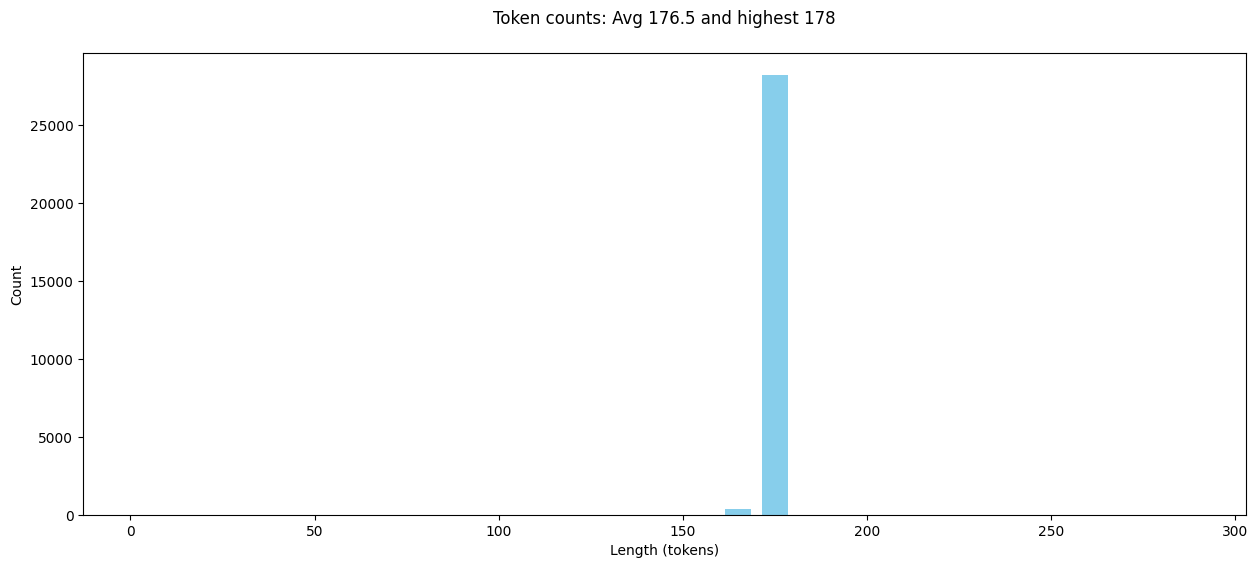

In [ ]:
# Plot the distribution of token counts again

tokens = [item.token_count for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Token counts: Avg {sum(tokens)/len(tokens):,.1f} and highest {max(tokens):,}\n")
plt.xlabel('Length (tokens)')
plt.ylabel('Count')
plt.hist(tokens, rwidth=0.7, color="skyblue", bins=range(0, 300, 10))
plt.show()

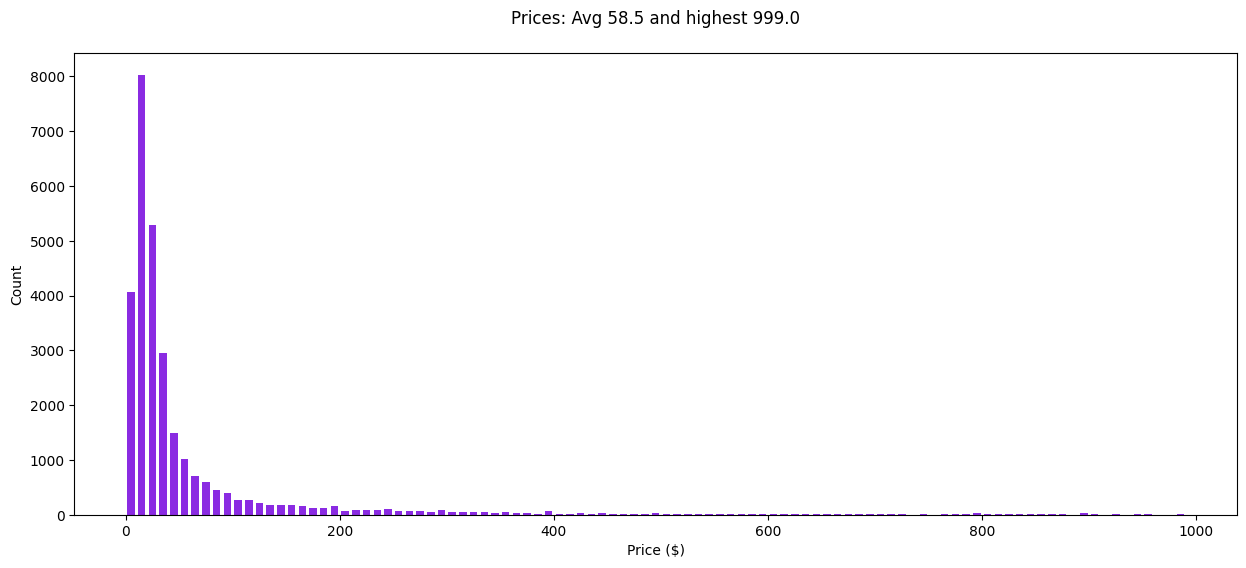

In [ ]:
# Plot the distribution of prices

prices = [item.price for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.1f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="blueviolet", bins=range(0, 1000, 10))
plt.show()

#### Dataset Curated!
We've crafted an excellent dataset.

Let's do some final checks

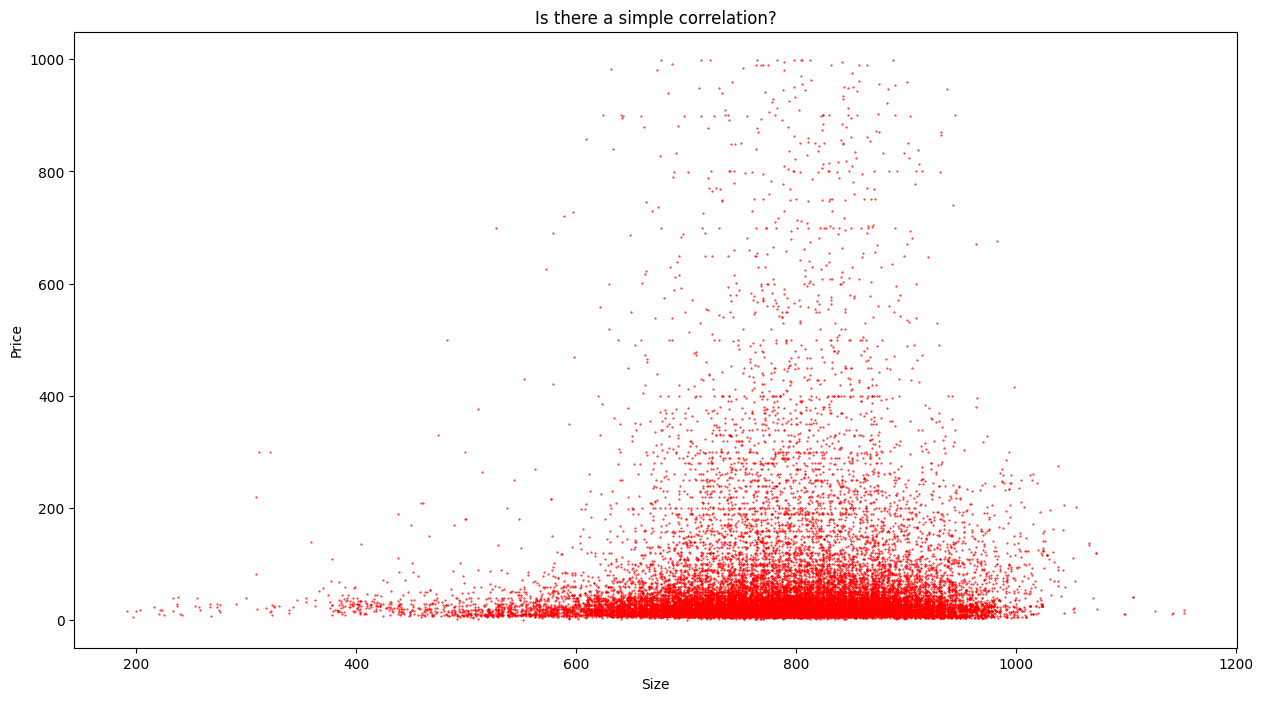

In [ ]:
# How does the price vary with the character count of the prompt?

sample = items

sizes = [len(item.prompt) for item in sample]
prices = [item.price for item in sample]

# Create the scatter plot
plt.figure(figsize=(15, 8))
plt.scatter(sizes, prices, s=0.2, color="red")

# Add labels and title
plt.xlabel('Size')
plt.ylabel('Price')
plt.title('Is there a simple correlation?')

# Display the plot
plt.show()

In [ ]:
def report(item):
    prompt = item.prompt
    tokens = Item.tokenizer.encode(item.prompt)
    print(prompt)
    print(tokens[-10:])
    print(Item.tokenizer.batch_decode(tokens[-10:]))

In [ ]:
report(sample[50])

How much does this cost to the nearest dollar?

285746 OR 285811 Washer Agitator Support And Dogs Compatible with Inglis, Whirlpool, Kenmore, Roper, Admiral
285746 OR 285811 Agitator support and dogs Washing machine agitator repair kit with a medium length cam Agitator support and dogs for two piece agitators.This kit should be used when the top part of the agitator is not moving properly but the bottom part is. Replaces Old Numbers 2744 285746 285811 Washer Agitator Repair Kit. This part works with the following brands Whirlpool, Roper, Admiral, Maytag, Hardwick, Jenn-Air, Estate, Magic Chef, Crosley, Inglis, Norge, Modern Maid, Amana, Kenmore

Price is $8.00
[11, 14594, 6518, 271, 7117, 374, 400, 23, 13, 410]
[',', ' Ken', 'more', '\n\n', 'Price', ' is', ' $', '8', '.', '00']


### Observation
An interesting thing about the Llama tokenizer is that every number from 1 to 999 gets mapped to 1 token, much as we saw with gpt-4o. The same is not true of qwen2, gemma and phi3, which all map individual digits to tokens. This does turn out to be a bit useful for our project, although it's not an essential requirement.

### 🧪 Data Splitting: Training, Validation, and Test Sets

We now partition our curated dataset into training, validation, and test subsets.

While it's common to allocate 5–10% of the data for testing, in our case we have a surplus of examples.  
To keep training efficient and focused, we will:

- Use **25,000 samples** for training  
- Reserve **2,000 samples** for testing (though not all may be used)

> Proper data splitting ensures reliable model evaluation and helps prevent overfitting.

In [ ]:
random.seed(42)
random.shuffle(sample)
train = sample[:25_000]
test = sample[25_000:27_000]
print(f"Divided into a training set of {len(train):,} items and test set of {len(test):,} items")

Divided into a training set of 25,000 items and test set of 2,000 items


In [ ]:
print(train[0].prompt)

How much does this cost to the nearest dollar?

and Replacement Range Cooktop Drip Pans fit GE, Hotpoint - Two 6 Inch and Two 8 Inch Pans (4 pieces)
Contents 2 x (6 inches) and 2 x (8 inches) bowls, 4 drip bowls total Compatibility This replacement kit works with GE, Hotpoint, Moffat, Monogram (GE), Profile (GE), RCA (GE), and Roper models prior to 1996. replaces 65975, replaces and 65974, 770169 Premium quality Drip bowls are made of durable high-quality material. It features a chrome finish, well-tested by the manufacturer. Durable, stick-free, easy to clean, and dishwasher safe. Ensure long-lasting and effective performance Easy to install Shut off electrical power, tilt the coil

Price is $12.00


In [ ]:
print(test[0].test_prompt())

How much does this cost to the nearest dollar?

Setpower Insulated Protective Cover for AJ30 Portable Refrigerator Freezer, suitable for AJ30 Only
Insulation & Waterproof well-made insulation could save battery power and improve cooling efficiency by preventing cold air from flowing away. Durable and Foldable with its oxford cloth outer layer, it's durable and protects your portable refrigerator from scratches and dust. Expanded Bag for Accessories two expanded bags on its side, expand space to store the other accessories. Great Ventilation a hollowed design for positions of vents doesn't affect the ventilation. Attention this insulated cover is ONLY suitable for SetPower AJ30 portable refrigerator. FIT TO AJ30 ONLY. Brand Name Setpower, Model Info AJ30 COVER, model number AJ30 COVER, Installation Type Freestanding, Part AJ30 cover, Special Features Portable, Color

Price is $


### 🚀 Final Step: Convert and Upload the Dataset to Hugging Face Hub

In the final step, we will convert our curated dataset into the **instruction-prompt format** required for fine-tuning and then **upload it to the Hugging Face Hub**.

This allows for:

- Seamless integration with Hugging Face training pipelines
- Easy sharing and reuse across projects or collaborators
- Version-controlled, cloud-hosted access to your datase

In [ ]:
train_prompts = [item.prompt for item in train]
train_prices = [item.price for item in train]
test_prompts = [item.test_prompt() for item in test]
test_prices = [item.price for item in test]

In [ ]:
# Create a Dataset from the lists

train_dataset = Dataset.from_dict({"text": train_prompts, "price": train_prices})
test_dataset = Dataset.from_dict({"text": test_prompts, "price": test_prices})
dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

In [ ]:
DATASET_NAME = "srajal87/lite-data"
dataset.push_to_hub(DATASET_NAME, private=True)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/25 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/srajal87/lite-data/commit/15716a10fac3b894d40248625ad3e97b89837bf5', commit_message='Upload dataset', commit_description='', oid='15716a10fac3b894d40248625ad3e97b89837bf5', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/srajal87/lite-data', endpoint='https://huggingface.co', repo_type='dataset', repo_id='srajal87/lite-data'), pr_revision=None, pr_num=None)

### 🤖 Model Selection and Baseline Evaluation

In this section, we will select an appropriate pretrained model for our task and evaluate its baseline performance on the product price prediction dataset.  
This provides a reference point to assess the improvements gained through fine-tuning.


In [ ]:
# pip installs - ignore the error message!

!pip install -q datasets requests torch peft bitsandbytes transformers trl accelerate sentencepiece tiktoken matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 366.3/366.3 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# imports

import os
import re
import math
from tqdm import tqdm
from google.colab import userdata
from huggingface_hub import login
import torch
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, TrainingArguments, set_seed
from peft import LoraConfig, PeftModel
from datasets import load_dataset, Dataset, DatasetDict
from datetime import datetime
import matplotlib.pyplot as plt

In [ ]:
LLAMA_3_1 = "meta-llama/Meta-Llama-3.1-8B"
BASE_MODEL = LLAMA_3_1
HF_USER = "srajal87"
DATASET_NAME = f"{HF_USER}/lite-data"
MAX_SEQUENCE_LENGTH = 182
QUANT_4_BIT = True

In [ ]:
DATASET_NAME

'srajal87/lite-data'

In [ ]:
# Log in to HuggingFace

hf_token = userdata.get('HF_TOKEN')
login(hf_token, add_to_git_credential=True)

## Load our data
We uploaded it to Hugging Face, so it's easy to retrieve it now

In [ ]:
dataset = load_dataset(DATASET_NAME)
train = dataset['train']
test = dataset['test']

README.md:   0%|          | 0.00/412 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/9.84M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/780k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
train[0]

{'text': 'How much does this cost to the nearest dollar?\n\nand Replacement Range Cooktop Drip Pans fit GE, Hotpoint - Two 6 Inch and Two 8 Inch Pans (4 pieces)\nContents 2 x (6 inches) and 2 x (8 inches) bowls, 4 drip bowls total Compatibility This replacement kit works with GE, Hotpoint, Moffat, Monogram (GE), Profile (GE), RCA (GE), and Roper models prior to 1996. replaces 65975, replaces and 65974, 770169 Premium quality Drip bowls are made of durable high-quality material. It features a chrome finish, well-tested by the manufacturer. Durable, stick-free, easy to clean, and dishwasher safe. Ensure long-lasting and effective performance Easy to install Shut off electrical power, tilt the coil\n\nPrice is $12.00',
 'price': 11.99}

In [ ]:
test[0]

{'text': "How much does this cost to the nearest dollar?\n\nSetpower Insulated Protective Cover for AJ30 Portable Refrigerator Freezer, suitable for AJ30 Only\nInsulation & Waterproof well-made insulation could save battery power and improve cooling efficiency by preventing cold air from flowing away. Durable and Foldable with its oxford cloth outer layer, it's durable and protects your portable refrigerator from scratches and dust. Expanded Bag for Accessories two expanded bags on its side, expand space to store the other accessories. Great Ventilation a hollowed design for positions of vents doesn't affect the ventilation. Attention this insulated cover is ONLY suitable for SetPower AJ30 portable refrigerator. FIT TO AJ30 ONLY. Brand Name Setpower, Model Info AJ30 COVER, model number AJ30 COVER, Installation Type Freestanding, Part AJ30 cover, Special Features Portable, Color\n\nPrice is $",
 'price': 65.99}

### ⚙️ Preparing the Base LLaMA Model for Evaluation

In this step, we load the **base LLaMA model** using **4-bit quantization** to optimize memory usage and computational efficiency during evaluation.

Quantized models significantly reduce resource requirements while maintaining comparable performance—making them ideal for experimentation and baseline assessment.

In [ ]:
## pick the right quantization

if QUANT_4_BIT:
  quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4"
  )
else:
  quant_config = BitsAndBytesConfig(
    load_in_8bit=True,
    bnb_8bit_compute_dtype=torch.bfloat16
  )

In [ ]:
# Load the Tokenizer and the Model

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

# Efficiently load a large LLM into limited memory using quantization.
base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    quantization_config=quant_config,
    device_map="auto",
)
base_model.generation_config.pad_token_id = tokenizer.pad_token_id

print(f"Memory footprint: {base_model.get_memory_footprint() / 1e9:.1f} GB")

tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/826 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

Memory footprint: 5.6 GB


In [ ]:
def extract_price(s):
    if "Price is $" in s:
      contents = s.split("Price is $")[1]
      contents = contents.replace(',','').replace('$','')
      match = re.search(r"[-+]?\d*\.\d+|\d+", contents)
      return float(match.group()) if match else 0
    return 0

In [ ]:
def model_predict(prompt):
    set_seed(42)
    inputs = tokenizer.encode(prompt, return_tensors="pt").to("cuda")
    attention_mask = torch.ones(inputs.shape, device="cuda")
    outputs = base_model.generate(inputs, max_new_tokens=4, attention_mask=attention_mask, num_return_sequences=1)
    response = tokenizer.decode(outputs[0])
    return extract_price(response)

In [ ]:
model_predict(test[0]['text'])

25.0

### 📊 Model Evaluation: Baseline Performance of LLaMA 3.1

Now, we evaluate the **base Meta-LLaMA-3.1** model on our test dataset to establish a baseline for performance.

This step helps us understand how well the pretrained model performs on the **product price prediction** task *without any fine-tuning*, providing a reference point for future improvements.

In [ ]:
## import testing
from testing import Tester

1: Guess: $25.00 Truth: $65.99 Error: $40.99 SLE: 0.90 Item: Setpower Insulated P...
2: Guess: $1.00 Truth: $9.68 Error: $8.68 SLE: 2.81 Item: TUAIC Refrigerator D...
3: Guess: $89.99 Truth: $155.98 Error: $65.99 SLE: 0.30 Item: Kegco Secondary Regu...
4: Guess: $7.99 Truth: $5.59 Error: $2.40 SLE: 0.10 Item: Refrigerator Door Sp...
5: Guess: $7.00 Truth: $98.40 Error: $91.40 SLE: 6.35 Item: Ice-O-Matic Float Va...
6: Guess: $19.99 Truth: $54.99 Error: $35.00 SLE: 0.96 Item: Wireless Temperature...
7: Guess: $7.99 Truth: $5.71 Error: $2.28 SLE: 0.09 Item: 3Inch Thermometer Hy...
8: Guess: $1.00 Truth: $9.53 Error: $8.53 SLE: 2.76 Item: GE GE Timer Knob Ass...
9: Guess: $7.00 Truth: $11.24 Error: $4.24 SLE: 0.18 Item: newlifeapp Dryer Lin...
10: Guess: $25.00 Truth: $12.88 Error: $12.12 SLE: 0.39 Item: Away NV350 NV351 NV3...
11: Guess: $25.00 Truth: $99.99 Error: $74.99 SLE: 1.84 Item: Refrigerator Ice Mak...
12: Guess: $7.99 Truth: $16.99 Error: $9.00 SLE: 0.48 Item: 2 PACKS Water Fil

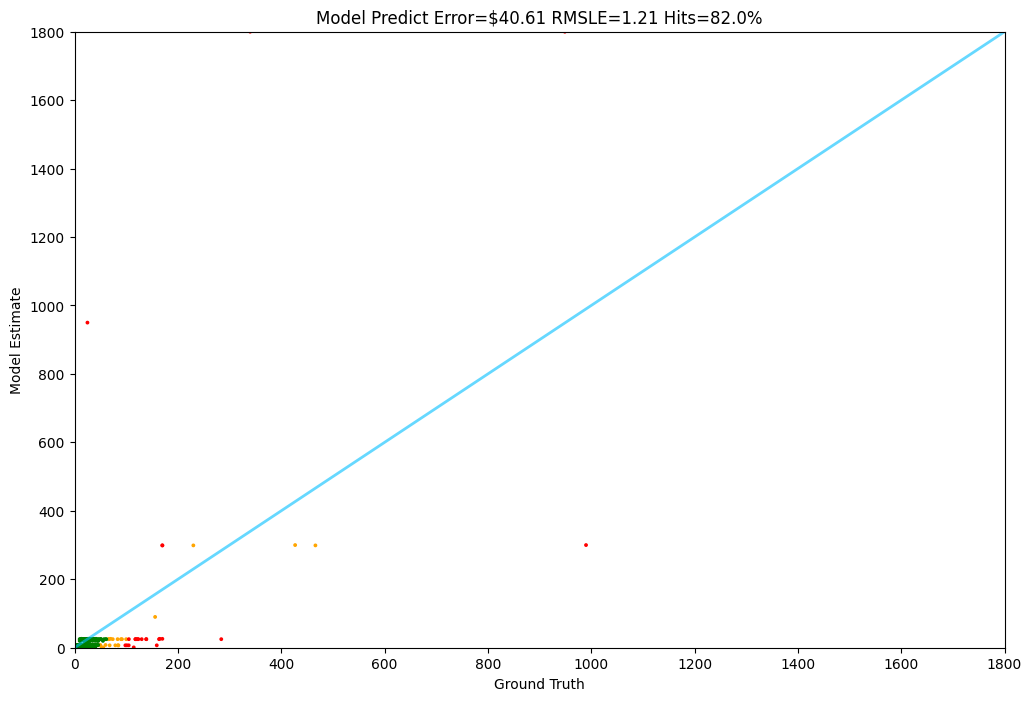

In [ ]:
Tester.test(model_predict, test)

# Fine-Tuning Llama

![](https://archive.is/0iIXL/5f30742c57ad532b4cda9f1b48790dbcc7d00a85.webp)

This section provides context on adapting large language models (LLMs), specifically **Meta-Llama-3.1-8B**, for the task of **predicting product prices** based on textual descriptions.

---

## 🔍 Summary

### 🧠 LLM Pretraining
Large Language Models like **LLaMA** are pretrained on extensive corpora of text, allowing them to model complex language patterns. However, this pretraining is **general-purpose** and not tailored to specific tasks such as regression or numerical prediction.

### 🎯 Task-Specific Fine-Tuning
Pretrained LLMs require **fine-tuning** to perform domain-specific tasks. In this notebook, we fine-tune the `meta-llama/Meta-Llama-3.1-8B` model to estimate product prices using the **Amazon Reviews 2023 (Appliances)** dataset.

### 📘 Supervised Fine-Tuning (SFT)
We use **Supervised Fine-Tuning (SFT)**, where the model is trained on labeled pairs:  
- **Input**: Product description  
- **Output**: Actual product price  

The goal is to minimize the prediction error between the model’s output and the true price. SFT is particularly effective when the target task was not part of the model’s pretraining distribution.

### ⚡ Parameter-Efficient Fine-Tuning (PEFT)
Fine-tuning all parameters of large models is resource-intensive. We apply **PEFT** techniques (e.g., LoRA) to fine-tune a small subset of the model’s weights, reducing compute and memory requirements without sacrificing performance.

### ✅ Importance of Data Quality
As demonstrated in the **LIMA** paper, the quality of the fine-tuning dataset significantly impacts results. Our task benefits from the **task-specific and high-quality Amazon Appliances dataset**, making it ideal for training a robust price predictor.

---

> With these foundations, we proceed to fine-tune a powerful LLaMA-based model for product price estimation in an efficient and scalable manner.

In [ ]:

!pip install -q datasets requests torch peft bitsandbytes transformers trl accelerate sentencepiece wandb matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 69.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 366.3/366.3 kB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# imports

import os
import re
import math
from tqdm import tqdm
from google.colab import userdata
from huggingface_hub import login
import torch
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments, set_seed, BitsAndBytesConfig
from datasets import load_dataset, Dataset, DatasetDict
import wandb
from peft import LoraConfig
from trl import SFTTrainer, SFTConfig
from datetime import datetime
import matplotlib.pyplot as plt

In [ ]:
# Constants

BASE_MODEL = "meta-llama/Meta-Llama-3.1-8B"
PROJECT_NAME = "pricer-lite"
HF_USER = "srajal87" # your HF name here!

# Data

DATASET_NAME = f"{HF_USER}/lite-data"
MAX_SEQUENCE_LENGTH = 182

# Run name for saving the model in the hub

RUN_NAME =  f"{datetime.now():%Y-%m-%d_%H.%M.%S}"
PROJECT_RUN_NAME = f"{PROJECT_NAME}-{RUN_NAME}"
HUB_MODEL_NAME = f"{HF_USER}/{PROJECT_RUN_NAME}"

# Hyperparameters for QLoRA

LORA_R = 32
LORA_ALPHA = 64
TARGET_MODULES = ["q_proj", "v_proj", "k_proj", "o_proj"]
LORA_DROPOUT = 0.1
QUANT_4_BIT = True

# Hyperparameters for Training

EPOCHS = 1 # you can do more epochs if you wish, but only 1 is needed - more is probably overkill
BATCH_SIZE = 4 # on an A100 box this can go up to 16
GRADIENT_ACCUMULATION_STEPS = 1
LEARNING_RATE = 1e-4
LR_SCHEDULER_TYPE = 'cosine'
WARMUP_RATIO = 0.03
OPTIMIZER = "paged_adamw_32bit"

# Admin config - note that SAVE_STEPS is how often it will upload to the hub
# I've changed this from 5000 to 2000 so that you get more frequent saves

STEPS = 50
SAVE_STEPS = 2000
LOG_TO_WANDB = True

%matplotlib inline

In [ ]:
HUB_MODEL_NAME

'srajal87/pricer-lite-2025-06-04_17.39.50'

In [ ]:
# Log in to HuggingFace

hf_token = userdata.get('HF_TOKEN')
login(hf_token, add_to_git_credential=True)

In [ ]:
# Log in to Weights & Biases
wandb_api_key = userdata.get('WANDB_API_KEY')
os.environ["WANDB_API_KEY"] = wandb_api_key
wandb.login()

# Configure Weights & Biases to record against our project
os.environ["WANDB_PROJECT"] = PROJECT_NAME
os.environ["WANDB_LOG_MODEL"] = "checkpoint" if LOG_TO_WANDB else "end"
os.environ["WANDB_WATCH"] = "gradients"

wandb: Currently logged in as: srajalsahu87 (srajalsahu87-madhav-institute-of-technology-science-gwalior) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
dataset = load_dataset(DATASET_NAME)
train = dataset['train']
test = dataset['test']

README.md:   0%|          | 0.00/412 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/9.84M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/780k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
train = train.select(range(5000))

In [ ]:
if LOG_TO_WANDB:
  wandb.init(project=PROJECT_NAME, name=RUN_NAME)

In [ ]:
# pick the right quantization

if QUANT_4_BIT:
  quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4"
  )
else:
  quant_config = BitsAndBytesConfig(
    load_in_8bit=True,
    bnb_8bit_compute_dtype=torch.bfloat16
  )

In [ ]:
# Load the Tokenizer and the Model

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    quantization_config=quant_config,
    device_map="auto",
)
base_model.generation_config.pad_token_id = tokenizer.pad_token_id

print(f"Memory footprint: {base_model.get_memory_footprint() / 1e6:.1f} MB")

tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/826 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

Memory footprint: 5591.5 MB


In [ ]:
from trl import DataCollatorForCompletionOnlyLM
response_template = "Price is $"
collator = DataCollatorForCompletionOnlyLM(response_template, tokenizer=tokenizer)

In [ ]:
# First, specify the configuration parameters for LoRA

lora_parameters = LoraConfig(
    lora_alpha=LORA_ALPHA,
    lora_dropout=LORA_DROPOUT,
    r=LORA_R,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=TARGET_MODULES,
)

# Next, specify the general configuration parameters for training

train_parameters = SFTConfig(
    output_dir=PROJECT_RUN_NAME,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=1,
    eval_strategy="no",
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    optim=OPTIMIZER,
    save_steps=SAVE_STEPS,
    save_total_limit=10,
    logging_steps=STEPS,
    learning_rate=LEARNING_RATE,
    weight_decay=0.001,
    fp16=False,
    bf16=True,
    max_grad_norm=0.3,
    max_steps=-1,
    warmup_ratio=WARMUP_RATIO,
    group_by_length=True,
    lr_scheduler_type=LR_SCHEDULER_TYPE,
    report_to="wandb" if LOG_TO_WANDB else None,
    run_name=RUN_NAME,
    max_seq_length=MAX_SEQUENCE_LENGTH,
    dataset_text_field="text",
    save_strategy="steps",
    hub_strategy="every_save",
    push_to_hub=True,
    hub_model_id=HUB_MODEL_NAME,
    hub_private_repo=True
)

# And now, the Supervised Fine Tuning Trainer will carry out the fine-tuning
# Given these 2 sets of configuration parameters
# The latest version of trl is showing a warning about labels - please ignore this warning

fine_tuning = SFTTrainer(
    model=base_model,
    train_dataset=train,
    peft_config=lora_parameters,
    args=train_parameters,
    data_collator=collator
  )

Converting train dataset to ChatML:   0%|          | 0/5000 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/5000 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/5000 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/5000 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [ ]:
# Fine-tune!
fine_tuning.train()

wandb: WARNING The get_url method is deprecated and will be removed in a future release. Please use `run.url` instead.


Step,Training Loss
50,1.663300
100,1.360900
150,1.465200
200,1.416100
250,1.437800
300,1.407200
350,1.456700
400,1.409200
450,1.430300
500,1.348100


wandb: Adding directory to artifact (./pricer-lite-2025-06-04_17.39.50/checkpoint-1250)... Done. 1.3s
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


TrainOutput(global_step=1250, training_loss=1.3777826965332032, metrics={'train_runtime': 14229.5868, 'train_samples_per_second': 0.351, 'train_steps_per_second': 0.088, 'total_flos': 4.035926914301952e+16, 'train_loss': 1.3777826965332032})

In [ ]:
# Push our fine-tuned model to Hugging Face
fine_tuning.model.push_to_hub(PROJECT_RUN_NAME, private=True)
print(f"Saved to the hub: {PROJECT_RUN_NAME}")

README.md:   0%|          | 0.00/1.51k [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


Saved to the hub: pricer-lite-2025-06-04_17.39.50


### 🧠 Load Fine-Tuned Model for Evaluation

In this section, we load the **fine-tuned LLaMA model** to evaluate its performance on the product price prediction task.

This model has been adapted from its pretrained state using **Supervised Fine-Tuning (SFT)** and **Parameter-Efficient Fine-Tuning (PEFT)** techniques, allowing it to better align with the structure and semantics of our curated dataset.

In [ ]:
# imports

import os
import re
import math
from tqdm import tqdm
from google.colab import userdata
from huggingface_hub import login
import torch
import torch.nn.functional as F
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, set_seed
from datasets import load_dataset, Dataset, DatasetDict
from datetime import datetime
from peft import PeftModel
import matplotlib.pyplot as plt

In [ ]:
import os

In [ ]:
# Constants

BASE_MODEL = "meta-llama/Meta-Llama-3.1-8B"
PROJECT_NAME = "pricer-lite"
HF_USER = "srajal87"

# The run itself

RUN_NAME = "2025-06-04_17.39.50"
PROJECT_RUN_NAME = f"{PROJECT_NAME}-{RUN_NAME}"
REVISION = "db3b1dbf14b9368e5777df70c94f2c8a82485a0b" # or REVISION = None
FINETUNED_MODEL = f"{HF_USER}/{PROJECT_RUN_NAME}"


# Data
DATASET_NAME = f"{HF_USER}/lite-data"


# Hyperparameters for QLoRA
QUANT_4_BIT = True

%matplotlib inline

In [ ]:
# Log in to HuggingFace

hf_token = userdata.get('HF_TOKEN')
login(hf_token, add_to_git_credential=True)

In [ ]:
dataset = load_dataset(DATASET_NAME)
train = dataset['train']
test = dataset['test']

README.md:   0%|          | 0.00/412 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/9.84M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/780k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
test[0]

{'text': "How much does this cost to the nearest dollar?\n\nSetpower Insulated Protective Cover for AJ30 Portable Refrigerator Freezer, suitable for AJ30 Only\nInsulation & Waterproof well-made insulation could save battery power and improve cooling efficiency by preventing cold air from flowing away. Durable and Foldable with its oxford cloth outer layer, it's durable and protects your portable refrigerator from scratches and dust. Expanded Bag for Accessories two expanded bags on its side, expand space to store the other accessories. Great Ventilation a hollowed design for positions of vents doesn't affect the ventilation. Attention this insulated cover is ONLY suitable for SetPower AJ30 portable refrigerator. FIT TO AJ30 ONLY. Brand Name Setpower, Model Info AJ30 COVER, model number AJ30 COVER, Installation Type Freestanding, Part AJ30 cover, Special Features Portable, Color\n\nPrice is $",
 'price': 65.99}

In [ ]:
# pick the right quantization (thank you Robert M. for spotting the bug with the 8 bit version!)

if QUANT_4_BIT:
  quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4"
  )
else:
  quant_config = BitsAndBytesConfig(
    load_in_8bit=True,
    bnb_8bit_compute_dtype=torch.bfloat16
  )

In [ ]:
# Load the Tokenizer and the Model

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    quantization_config=quant_config,
    device_map="auto",
)
base_model.generation_config.pad_token_id = tokenizer.pad_token_id

# Load the fine-tuned model with PEFT
if REVISION:
  fine_tuned_model = PeftModel.from_pretrained(base_model, FINETUNED_MODEL, revision=REVISION)
else:
  fine_tuned_model = PeftModel.from_pretrained(base_model, FINETUNED_MODEL)


print(f"Memory footprint: {fine_tuned_model.get_memory_footprint() / 1e6:.1f} MB")

tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/826 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/811 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/109M [00:00<?, ?B/s]

Memory footprint: 5700.6 MB


In [ ]:
fine_tuned_model

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora

### ✅ Evaluating the Fine-Tuned Model

With the fine-tuned LLaMA model loaded, we now assess its performance on the test dataset.

This evaluation allows us to:

- Measure improvements over the baseline (pretrained) model
- Understand how well the model has learned to map product descriptions to price estimates
- Identify potential areas for further optimization

We’ll compare predicted prices against actual values using appropriate regression metrics such as **Mean Absolute Error (MAE)** or **Root Mean Squared Error (RMSE)**.

In [ ]:
def extract_price(s):
    if "Price is $" in s:
      contents = s.split("Price is $")[1]
      contents = contents.replace(',','')
      match = re.search(r"[-+]?\d*\.\d+|\d+", contents)
      return float(match.group()) if match else 0
    return 0

In [ ]:
# Original prediction function takes the most likely next token

def model_predict(prompt):
    set_seed(42)
    inputs = tokenizer.encode(prompt, return_tensors="pt").to("cuda")
    attention_mask = torch.ones(inputs.shape, device="cuda")
    outputs = fine_tuned_model.generate(inputs, attention_mask=attention_mask, max_new_tokens=3, num_return_sequences=1)
    response = tokenizer.decode(outputs[0])
    return extract_price(response)

In [ ]:
# An improved prediction function takes a weighted average of the top 3 choices
# That Llama generates 1 token for any 3 digit number

top_K = 3

def improved_model_predict(prompt, device="cuda"):
    set_seed(42)
    inputs = tokenizer.encode(prompt, return_tensors="pt").to(device)
    attention_mask = torch.ones(inputs.shape, device=device)

    with torch.no_grad():
        outputs = fine_tuned_model(inputs, attention_mask=attention_mask)
        next_token_logits = outputs.logits[:, -1, :].to('cpu')

    next_token_probs = F.softmax(next_token_logits, dim=-1)
    top_prob, top_token_id = next_token_probs.topk(top_K)
    prices, weights = [], []
    for i in range(top_K):
      predicted_token = tokenizer.decode(top_token_id[0][i])
      probability = top_prob[0][i]
      try:
        result = float(predicted_token)
      except ValueError as e:
        result = 0.0
      if result > 0:
        prices.append(result)
        weights.append(probability)
    if not prices:
      return 0.0, 0.0
    total = sum(weights)
    weighted_prices = [price * weight / total for price, weight in zip(prices, weights)]
    return sum(weighted_prices).item()

1: Guess: $30.56 Truth: $65.99 Error: $35.43 SLE: 0.57 Item: Setpower Insulated P...
2: Guess: $8.05 Truth: $9.68 Error: $1.63 SLE: 0.03 Item: TUAIC Refrigerator D...
3: Guess: $82.88 Truth: $155.98 Error: $73.10 SLE: 0.39 Item: Kegco Secondary Regu...
4: Guess: $9.03 Truth: $5.59 Error: $3.44 SLE: 0.18 Item: Refrigerator Door Sp...
5: Guess: $41.75 Truth: $98.40 Error: $56.65 SLE: 0.71 Item: Ice-O-Matic Float Va...
6: Guess: $24.53 Truth: $54.99 Error: $30.46 SLE: 0.62 Item: Wireless Temperature...
7: Guess: $7.99 Truth: $5.71 Error: $2.28 SLE: 0.09 Item: 3Inch Thermometer Hy...
8: Guess: $10.99 Truth: $9.53 Error: $1.46 SLE: 0.02 Item: GE GE Timer Knob Ass...
9: Guess: $11.58 Truth: $11.24 Error: $0.34 SLE: 0.00 Item: newlifeapp Dryer Lin...
10: Guess: $34.75 Truth: $12.88 Error: $21.87 SLE: 0.90 Item: Away NV350 NV351 NV3...
11: Guess: $129.75 Truth: $99.99 Error: $29.76 SLE: 0.07 Item: Refrigerator Ice Mak...
12: Guess: $19.09 Truth: $16.99 Error: $2.10 SLE: 0.01 Item: 2 PACKS Wate

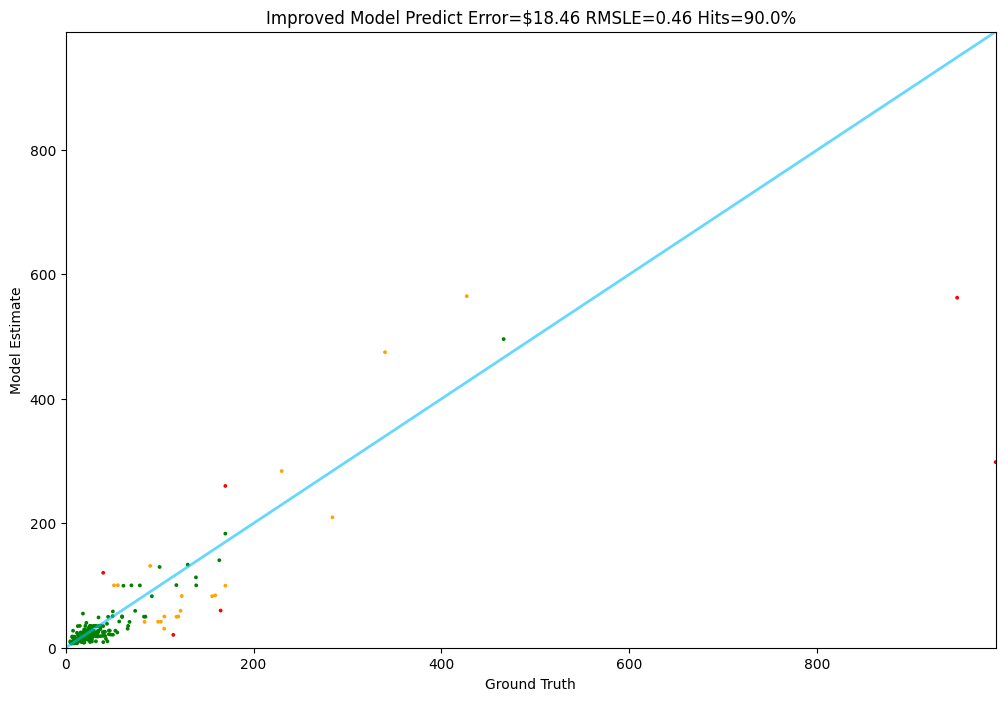

In [ ]:
Tester.test(improved_model_predict, test)